# Daniel Bain
# Udacity Deep Reinforcement Learning Course
# Project #3: Collaboration and Competition

---


This is the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.  In this notebook, I am applying reinforcement learning algorithms to learn to keep a ball in play in a very simple 2-player computer tennis game.

In order to make it easy to follow along, all relevant code for this project is contained in this Jupyter Notebook.  I'll do my best to explain the background of the project, the approach, and the code and hyperparameters utilized.

With minimal modification, the DDPG code I implemented for Project 2 (https://github.com/danielbain/Deep-Reinforcement-Learning/tree/master/Udacity_P2_Continuous_Control) solved this project.  That network used a method to apply a __deterministic policy gradient__.  

As this is the last assignment for this course, I decided to take some extra time to play with and implement some enhancements to the code:

- Added information to each state identifying the agent.
- Added Residual Neural Network Layers to experiment with this exciting technique;
- Attempted to Implement Prioritized Experience Replay

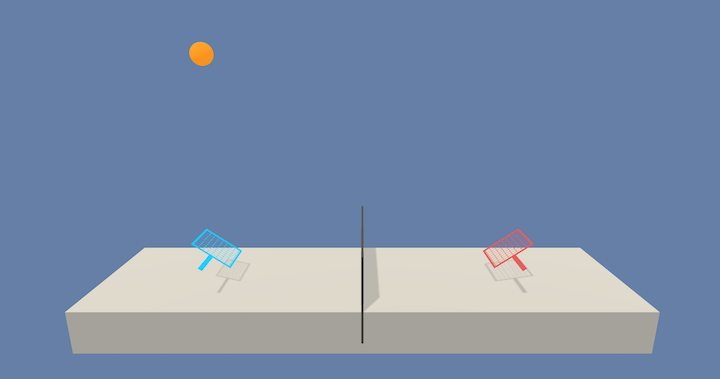


## 1. Background

For this project, we have been asked to apply a self learning neural network to operate in an environment that has multiple agents.  

In this case to play a simple game of tennis to control two agents rackets to hit a ball back and forth over a net. 


### A. Tennis Environment

For the tennis environment, which is a slightly modified version of the Unity Tennis environment, if an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

The task is episodic, and in order to solve the environment, agents must get an average score of +0.5 (over 100 consecutive episodes, after taking the maximum over both agents).  Specifically,

- After each episode, the rewards that each agent received are added up (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 scores.
- This yields a single **score** for each episode.

The environment is considered solved, when the average (over 100 episodes) of those scores is at least +0.5.


### B. Deterministic Policy Gradients

__Deterministic policy gradients__ are a method of Actor to Critic (A2C) reinforcement learning that have been shown to significantly outperform stochastic A2C methods in larger action spaces.  _see_: Silver et al., Deterministic Policy Gradient Algorithms (2014), http://proceedings.mlr.press/v32/silver14.pdf.

Whereas, e.g. using standard A2C learning, ___stochastic policy gradient___ methods return a probability distribution that we sample from to determine the best course of action in a state, ___deterministic policy gradient___ methods directly provide a ___specific best action to take from every state___.

In theorems presented in the paper referenced above, the authors first show that a stochastic policy gradient is essentially ___equivalent___ to a deterministic policy gradient.  Then they show that deterministic gradients are compatible with function approximators, such as neural networks.

The authors explain several important features of deterministic policy gradients that, they assert, make them more effective at learning for higher dimensional problems than stochastic policy gradients.  First, stochastic gradients become extremely complex to calculate because stochastic gradients change more rapidly near the mean and their variance grows to infinity as the policy becomes deterministic.  In larger action spaces the calculations are even more complex.  

Moreover, ___a determinstic policy allows for off-policy learning___ (as with off-policy DQN methods, exploration is achieved via random actions taken during training).  Also, a deterministic policy works with the chain rule to determine Q-values--and thereby allows us to maximize Q-values and better optimize learning while simultaneously finding the best policy.


#### 1. DDPG

In 2016, Google Deep Mind published a follow-up paper that introduced a _deep_ deterministic policy gradient method they called __DDPG__ ("Deep Deterministic Policy Gradient"). _see_: Lillicrap et al., Continuous Control with Deep Reinforcement Learning (2016), https://arxiv.org/pdf/1509.02971.pdf.  

DDPG uses 2 deep neural networks (akin to an actor-critic network) to demonstrate the efficacy of deterministic policy gradients at solving continuous control problems.  

The pseudocode for the DDPG algorithm from the Google Deep Mind paper is referenced below:

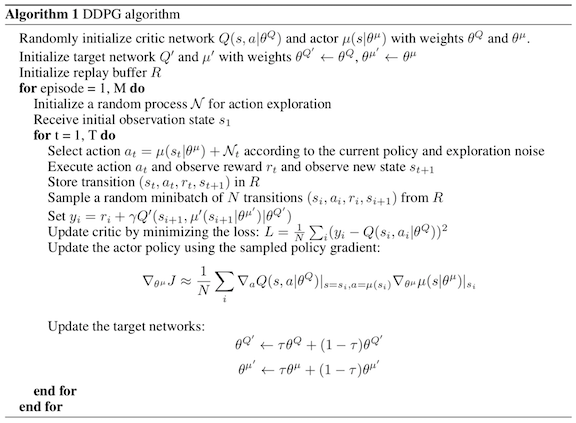

In the DDPG paper, the authors demonstrated that this single algorithm is "___model free___" by successfully training it to solve 20 different simulated physics tasks.


#### 2. D4PG

Earlier this year, in April 2018, Google Deep Mind published details about an updated algorithm that they called __D4PG__ ("Distributed Distributional Deterministic Policy Gradients").  _see_: Barth-Maron et al., Distributed Distributional Deterministic Policy Gradients (2018), https://arxiv.org/pdf/1804.08617.pdf.

D4PG provides several useful improvements to application of deterministic policy gradients for continuous control problems.  First, it applies a __distributional__ version of the critic update as well as distributed parallel actors __which together result in better, more stable gradients and improved learning performance__.  In addition, D4PG applies some of the "rainbow" of improvements made to the DQN value network such as N -step returns and prioritization of the experience replay.  I discussed and applied some of these improvements in the first project of this course.  (_see_: https://github.com/danielbain/Deep-Reinforcement-Learning/tree/master/Udacity_P1_Navigation)

The pseudocode for the D4PG algorithm from the Google Deep Mind paper is referenced below:

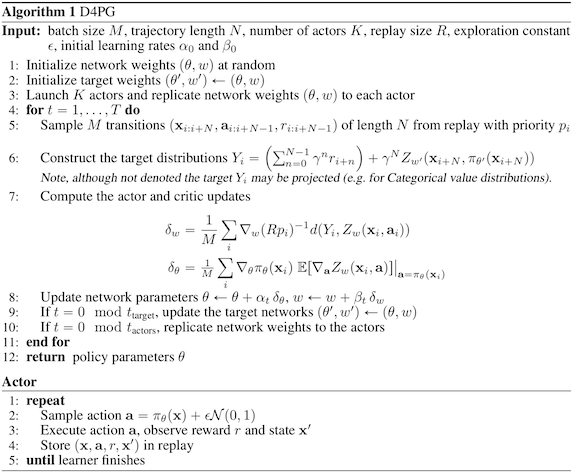


#### 3. MADDPG

MADDPG is a modification of DDPG that allows several actors to learn separately on their own actor network but sharing a single "all-knowing" critic that is able to see all their collective state information.  (See https://arxiv.org/pdf/1706.02275.pdf). 

## 2. Load Packages & Set Up Environment

First step is to import the necessary packages.  Here I am importing the Unity Environment as well as numpy, Pytorch, etc.

If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment

import numpy as np

import random

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

import copy

from collections import namedtuple, deque

import datetime

import matplotlib.pyplot as plt
%matplotlib inline




Next, we will start the Unity environment.  The `file_name` parameter needs to be changed to match the location of the Unity environment.  I have included the Mac OS X environment in this Github repo so to get this to run on a local machine it will be necessary to change the file path to work on your own local machine (or load the relevant environment for your machine).

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```


In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

The code cell below prints some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]




## 3. Implement DDPG

### A. Set up Actor and Critic Neural Network Models

Next step, I will set up the actor and critic neural networks for DDPG.

I have structured the actor and critic networks the same way that is described in the Google Deep Mind DDPG paper referenced above.  In Section 7, Supplementary Information, the authors described the generalized network that they used:

>We used Adam (Kingma & Ba, 2014) for learning the neural network parameters with a learning rate of 10−4 and 10−3 for the actor and critic respectively. For Q we included L2 weight decay of 10−2 and used a discount factor of γ = 0.99. For the soft target updates we used τ = 0.001. The neural networks used the rectified non-linearity (Glorot et al., 2011) for all hidden layers. The final output layer of the actor was a tanh layer, to bound the actions. The low-dimensional networks had 2 hidden layers with 400 and 300 units respectively (≈ 130,000 parameters). Actions were not included until the 2nd hidden layer of Q. When learning from pixels we used 3 convolutional layers (no pooling) with 32 filters at each layer. This was followed by two fully connected layers with 200 units (≈ 430,000 parameters).  The final layer weights and biases of both the actor and critic were initialized from a uniform distribution [−3 × 10−3, 3 × 10−3] and [3 × 10−4, 3 × 10−4] for the low dimensional and pixel cases respectively. This was to ensure the initial outputs for the policy and value estimates were near zero.  

#### 1.  DDPG Architecture based on Google Deep Mind DDPG Paper

The basic actor is a straightforward feed forward neural network with two hidden layers, similar to that described in above-referenced Google Deep Mind DDPG paper.  The input is the state observation vector while the output is a vector with values for each possible action.  The last layer is a tanh activation function which gives an output between -1 and 1.

See below a quick sketch of the actor and critic network structures:

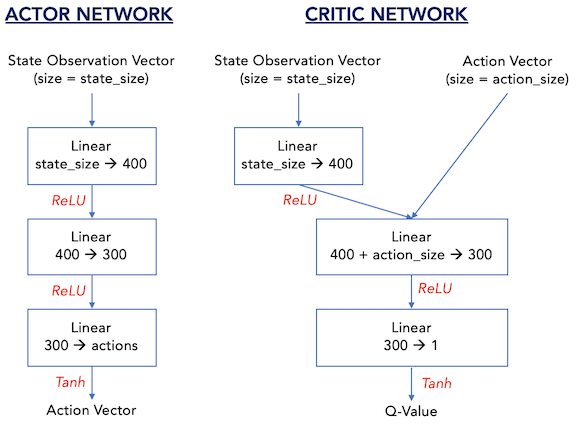

As described above in the Google Deep Mind paper, the actor network takes the vector of the observation state as an input and outputs a vector of actions.  The critic network takes the vector of the observation state as input and, after the first ReLU activation layer, takes the vector of actions from the actor network as an input.  The output for the critic network is a single Q value.

#### 2.  DDPG with Residual Neural Network Layers

In addition to the basic DDPG structure described above, for this assignment I also experimented with deeper **Residual Neural Network** layers.  Residual Neural networks were introduced in a paper by Microsoft Research in 2015 (Kaiming He et al., Deep Residual Learning for Image Recognition, https://arxiv.org/pdf/1512.03385.pdf).

This architecture took the AI community by storm because the strategy, it turns out, allows for significantly better performance and accuracy.  In fact, Microsoft and others have utilized this and similar strategies to win Kaggle competitions and ***surpass human ability*** in a variety of domains.

The idea was that deeper networks would be more effective at finding more levels of abstraction to approximate complex functions.  The problem had been that as neural networks become deeper, they become much more difficult to train because, among other things, deeper networks suffer from ***vanishing gradients*** when back-propagating.  

Residual Neural Networks utilize an innovative strategy known as ***skip connections*** to solve the vanishing gradient problem.  As illustrated below in a figure from the above-referenced Microsoft Research paper, Residual Networks effectively skip over a layer by simply adding the results from the previous layer to the final output.

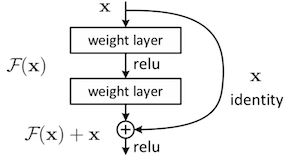

The point of the above structure is that the neural network is able to utilize the identity mapping and therefore not lose information despite added layers--but still get the possible benefits of added abstraction that additional layers provide.

While Residual Layers are definitely not needed to solve this Tennis playing task, which is easily solved with the basic architecture described in part 1 above, I thought it would be fun to experiment with and implement this technique.  Also, Google Deep Mind utilized deep Residual Networks in Alpha Zero--so the technique **is** used to solve cutting edge reinforcement learning problems where higher levels of abstraction are required.

Because I am running this assignment on my MacBookPro CPU and because the problem does not warrant a very deep network, I only demonstrate that a very basic Residual Network converges to solve the problem within a reasonable time frame.

My implementation relies on 4 ***additional*** residual layers in both the actor and critic networks *after* the first three layers described above, followed by the same final layer as above.  To keep the network extremely simple, I keep the network dimensions and number of nodes in each of the residual layers constant, matching the number from the second hidden layer.  Had I included convolutions or changed the number of nodes between layers, I would have simply, as described in the Microsoft Research paper, added a couple lines of code to the residual layers to allow the identity matrix to map to the changed dimensions.

In [5]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, resnet=False, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.resnet = resnet
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        if self.resnet:
            self.res1 = nn.Linear(fc2_units, fc2_units)
            self.res2 = nn.Linear(fc2_units, fc2_units)
            self.res3 = nn.Linear(fc2_units, fc2_units)
            self.res4 = nn.Linear(fc2_units, fc2_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)    # Deep Mind set to -3e-4 for pixels
        if self.resnet:
            self.res1.weight.data.uniform_(*hidden_init(self.res1))
            self.res2.weight.data.uniform_(*hidden_init(self.res2))
            self.res3.weight.data.uniform_(*hidden_init(self.res3))
            self.res4.weight.data.uniform_(*hidden_init(self.res4))

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        
        # Here I add the residual layers
        if self.resnet:
            residual = x
            x = F.relu(self.res1(x))
            x += residual
        
            residual = x
            x = F.relu(self.res2(x))
            x += residual
        
            residual = x
            x = F.relu(self.res3(x))
            x += residual
        
            residual = x
            x = F.relu(self.res4(x))
            x += residual
        
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, resnet=False, fcs1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.resnet = resnet
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        if self.resnet:
            self.res1 = nn.Linear(fc2_units, fc2_units)
            self.res2 = nn.Linear(fc2_units, fc2_units)
            self.res3 = nn.Linear(fc2_units, fc2_units)
            self.res4 = nn.Linear(fc2_units, fc2_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)    # Deep Mind set to -3e-4 for pixels
        if self.resnet:
            self.res1.weight.data.uniform_(*hidden_init(self.res1))
            self.res2.weight.data.uniform_(*hidden_init(self.res2))
            self.res3.weight.data.uniform_(*hidden_init(self.res3))
            self.res4.weight.data.uniform_(*hidden_init(self.res4))

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        
        # Here I add the residual layers
        if self.resnet:
            residual = x
            x = F.relu(self.res1(x))
            x += residual
        
            residual = x
            x = F.relu(self.res2(x))
            x += residual
        
            residual = x
            x = F.relu(self.res3(x))
            x += residual
        
            residual = x
            x = F.relu(self.res4(x))
            x += residual
        
        return self.fc3(x)

### B. Set up and Instantiate the Learning Agents

Next step is to set up an Agent to translate state observations into actions and to interact and learn from the environment using the actor and critic networks defined above.  


#### 1.  DDPG trained with a single Actor and Critic

The DDPG Agent class defined below is modified from code provided in the Udacity course from previous examples of agents from bipedal and pendulum assignments.

This function basically loops through each of the agents when stepping forward through the function.

In order to ensure exploration, noise is added to agent actions using Ornstein-Uhlenbeck (OU) Process (OU Process applies stochastic noise based on the physics of Brownian motion of a particle).  After adding noise, actions are clipped to ensure that they fall within the range -1 to +1.



#### 2.  Implement *Prioritized Experienced Replay*

Use of ***Prioritized Experience Replay*** to improve performance of a DQN was first described in a paper by Google Deep Mind in 2016 (Schaul et al., *Prioritized Experience Replay*, Feb 2016, https://arxiv.org/pdf/1511.05952.pdf).

In a *plain vanilla Replay* buffer, experiences are uniformly sampled from the replay buffer, regardless of their significance.  By contrast, in a ***Prioritized Experience Replay*** buffer, important transitions are replayed more frequently, and therefore learn more efficiently.  This method has demonstrated significantly improved performance over other approaches.  Biased sampling is extremely useful in reinforcement learning since the reward signal is often sparse and data distribution depends on the agent’s policy. 

The authors of the paper describe two methods for prioritizing experience replay, **(i)** a direct ***proportional*** prioritization; and **(ii)** ***rank based*** prioritization.  While the authors expected rank based prioritization to perform better (because it should be able to perform better in sparse data sets), in tests the authors found that the two methods performed similarly.

One issue the authors raise is that Stochastic Gradient Descent ("SGD") relies on the assumption that sampled variables are ***independent and identically distributed*** ("***IID***") but prioritizing samples messes up IID.  In order to address this problem the authors adjust the priorities of the sample weights using ***Importance Sampling*** (***IS***):

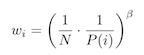

The authors note that the unbiased nature of updates is most important near convergence and therefore beta variable in the formula above is linearly annealed towards 1 throughout training.  When beta is equal to one, the Importance Sampling (IS) weights fully compensate for the non-uniform P(i).

It is worth noting that, in 2018, Google Deep Mind published a paper extending their work on Priority Experience Replay and applying the algorithm to distributed architectures (Horgan et al., Distributed Prioritized Experience Replay, May 2018, https://arxiv.org/pdf/1803.00933.pdf).  They refer to their new approach as ***Ape-X***.

To implement Prioritized Experience Replay, I looked at implementations of both proportional and rank based methods:

- A simple ***proportional*** prioritization implementation using a Sum Tree to track priorities is demonstrated at: https://github.com/rlcode/per and also at https://github.com/openai/baselines.

- I also found several good implementations of ***rank based*** prioritization implementations.  See, e.g.,: https://github.com/Damcy/prioritized-experience-replay

Because of the simplicity of the proportional implementation above, I decided to start with implementing this method utlizing a Sum Tree, starting with the reference code above.  In addition, I noticed that Google Deep Mind researchers also utilized *proportional* prioritization earlier this year in the 2018 distributed architecture paper referenced above.

The operation of the Sum Tree is quite simple and clever.  Rather than reshuffle data in memory to track priorities, 


>Proportional prioritization The ‘sum-tree’ data structure used here is very similar in spirit to the array representation of a binary heap. However, instead of the usual heap property, the value of a parent node is the sum of its children. Leaf nodes store the transition priorities and the internal nodes are intermediate sums, with the parent node containing the sum over all priorities, ptotal. This provides a efficient way of calculating the cumulative sum of priorities, allowing O(log N ) updates and sampling. To sample a minibatch of size k, the range [0, ptotal] is divided equally into k ranges.
>
>Next, a value is uniformly sampled from each range. Finally the transitions that correspond to each of these sampled values are retrieved from the tree. Overhead is similar to rank-based prioritization.

The following blog does a good job explaining the Sum Tree (but references code that is missing some steps): https://jaromiru.com/2016/11/07/lets-make-a-dqn-double-learning-and-prioritized-experience-replay/

I also found the explanation at the following link provides extremely helpful explanations of each of the steps to implement prioritized experience replay code: 
https://gist.github.com/simoninithomas/d6adc6edb0a7f37d6323a5e3d2ab72ec#file-dueling-deep-q-learning-with-doom-double-dqns-and-prioritized-experience-replay-ipynb

Also, there is a good walk-through of code in Maxim Lapan's book *Deep Reinforcement Learning Hands On* from Packt Publishing (https://www.packtpub.com/big-data-and-business-intelligence/deep-reinforcement-learning-hands). 

In summary, the steps to implement Prioritized Experience Replay are:
- Implement a new replay buffer that will track priorities, sample a batch according to them, calculate weights and update priorities after the loss has been determined. 
- Change the loss function to incorporate weights for every sample and pass loss values back to the replay buffer to adjust the priorities of sampled transitions.

Also worth mentioning that I struggled with keeping tensor shapes consistent and found this article to be very helpful:  http://deeplizard.com/learn/video/fCVuiW9AFzY

I also noted that many of the implementations in GitHub are incomplete because they do not include Importance Sampling, an important attributed described in the original Deep Mind paper.  

In [6]:
class DDPGAgent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, num_agents, random_seed, resnet=False, prioritized_replay=True):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            num_agents (int): number of agents
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)
        self.resnet = resnet
        self.prioritized_replay = prioritized_replay

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed, resnet).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed, resnet).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed, resnet).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed, resnet).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise((num_agents, action_size), random_seed)

        # Replay memory
        if self.prioritized_replay:
            self.memory = PER_Buffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        else:
            self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """
        Save experience in replay memory, and use random sample from buffer to learn.
        """
        
        for i in range(self.num_agents):
            self.memory.add(state[i,:], action[i,:], reward[i], next_state[i,:], done[i], self)
            
        # Learn from experiences, if enough samples are available in memory
        
        if self.prioritized_replay:
            """
            If prioritized experience replay, get batch experiences, index & IS weight
            """
            if len(self.memory) > BATCH_SIZE:
                experiences, idxs, is_weight = self.memory.sample()
                self.learn_per(experiences, GAMMA, idxs, is_weight) 
        else:
            """
            Otherwise, if not prioritized experience replay, then just get batch of experiences
            """
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)   
            
    def act(self, states, add_noise=True):
        """
        Returns actions for given state as per current policy.
        """
        states = torch.from_numpy(states).float().to(device)
        actions = np.zeros((self.num_agents, self.action_size))
        self.actor_local.eval()
        with torch.no_grad():
            for agent_num, state in enumerate(states):
                action = self.actor_local(state).cpu().data.numpy()
                actions[agent_num, :] = action
        self.actor_local.train()
        if add_noise:
            actions += self.noise.sample()
        return np.clip(actions, -1, 1)
    
    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """
        Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Get experiences from replay buffer
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_losses = -self.critic_local(states, actions_pred).mean()

        # Minimize the actor loss
        self.actor_optimizer.zero_grad()
        actor_losses.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)  
        
        
    def learn_per(self, experiences, gamma, idxs, is_weights):
        """
        Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        For prioritized experience replay, calculate loss adjusted by IS Weight & update priority 
        after learning step (higher priority samples will be seen more, so should be weighted 
        less to compensate)  
        
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Get experiences from replay buffer
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #

        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        # Use IS Weights from prioritized replay to determine batch weights
        Q_batch_weights = torch.FloatTensor(is_weights)
        # Manually calculate mean squared error adjusted by Batch Weights (from PER IS weights)
        critic_losses = Q_batch_weights * (Q_targets - Q_expected) ** 2
        critic_loss = critic_losses.mean()
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_losses = -self.critic_local(states, actions_pred)
        actor_loss = actor_losses.mean()
        
        # Minimize the actor loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # ------------------------- update priorities -------------------------- #
        prios = actor_losses + 1e-5
        errors = torch.abs(prios).detach().data.numpy()
        errors = errors.reshape(1,-1)
        errors = errors.squeeze()
        for i in range(BATCH_SIZE):
            idx = idxs[i]
            self.memory.batch_update(idx, errors[i])

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU) 

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

Below is a non-prioritized replay buffer:

In [7]:
# Regular (non-prioritized) replay buffer

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done, agent):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    


Below I will implement Prioritized Experience Replay SumTree and Memory:

In [8]:
"""
Implementation of Prioritized Experience Replay by modifying non prioritized memory buffer
Plus adjustments to code from https://github.com/rlcode/per

This implementation is utilizing PROPORTIONAL Prioritization
"""

class PER_Buffer:
    
    """
    PER_e                         :  PER Epsilon is a small positive constant that ensures that no transition 
                                      has zero priority
                   
    PER_a                         :  PER Alpha determines how much we sample randomly versus with priority.  
                                      Closer to 0 is uniform  
                                      randomness and closer to 1 favors experiences with the highest priorities.
                   
    PER_b                         :  PER Beta controls how much Importance Sampling ('IS') weights affect 
                                      learning, beta is annealed to 1 during training--and as beta approaches 
                                      1, IS weights compensate for non uniform probabilities
                    
    PER_b_increment_per_sampling  :  PER Beta Increment Per Sampling is how much PER Beta changes for each sample
    
    absolute_error_upper          :  Clipped absolute error
    """

    PER_e = 0.01
    PER_a = 0.6
    PER_b = 0.4
    PER_b_increment_per_sampling = 0.001
    absolute_error_upper = 1.
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.tree = SumTree(buffer_size)
        self.buffer_count = 0
    
    def _get_priority(self, error):
        # Priority = (error + PER_e) * PER_b
        return (error + self.PER_e) ** self.PER_a
    
    def add(self, state, action, reward, next_state, done, agent):
        """Add a new experience & priority to memory tree (using loss from actor network vs critic).
        To start, each new experience will get max priority.
        """
        
        # Experience to add to memory
        e = self.experience(state, action, reward, next_state, done)
        
        """
        Below method would be an option if new actions required extra attention (such as 
        constantly changing environments).  Given that this environment is pretty static, decided to 
        instead calculate actor loss for each new experience rather than prioritizing it.
        """
#         # Find the max priority
#         max_priority = np.max(self.tree.tree[-self.tree.capacity:])
        
#         # If the max priority = 0 we can't put priority = 0 since this exp will never have a chance to be selected
#         # So we use a minimum priority
#         if max_priority == 0:
#             max_priority = self.absolute_error_upper
        
#         self.tree.add(max_priority, e)   # set the max p for new p

        
        ###  Calclulate error (actor loss) in order to determine priority
        # first get tensor of states
        states = torch.tensor(state).float().to(device)
        # Re-shape states tensor to 1 row (1x24 for tennis)
        states = states.squeeze().unsqueeze(dim=0)
        
        ### Get action prediction and actor loss without calculating gradient
        agent.actor_local.eval()
        with torch.no_grad():
            action_pred = agent.actor_local(states)
            # Re-shape action tensor to 1 row so it can be easily appended to network
            action_pred = action_pred.reshape([1,-1]).squeeze().unsqueeze(dim=0)            
            actor_loss = -agent.critic_local(states, action_pred).mean()
        agent.actor_local.train()
        
        error = abs(actor_loss)
        
        # calculate priority & add priority & experience to tree
        p = (error + self.PER_e) ** self.PER_a
        self.tree.add(p, e)
        
        # update buffer size counter until it reaches minimum batch size
        if self.buffer_count < self.buffer_size:
            self.buffer_count += 1
 
    def sample(self):
        """ Sample from memory using prioritized experience replay"""
        
        # Create sample arrays that will contain the minibatches, indices, & priorities
        memory_b = []
        b_idx = np.empty((self.batch_size,), dtype=np.int32)
        b_ISWeights = np.empty((self.batch_size, 1), dtype=np.float32)
        
        # Calculate the priority segment by dividing the Range[0, ptotal] into n ranges
        priority_segment = self.tree.total_priority / self.batch_size

        # Anneal PER Beta to 1 by increment, allowing IS weights more effect for each minibatch 
        self.PER_b = np.min([1., self.PER_b + self.PER_b_increment_per_sampling])
        
        # Calculate max weight
        p_min = np.min(self.tree.tree[-self.tree.capacity:]) / self.tree.total_priority
        max_weight = (p_min * self.batch_size) ** (-self.PER_b)
        
        for i in range(self.batch_size):
            # Sample a value uniformly from each rach
            a, b = priority_segment * i, priority_segment * (i + 1)
            s = random.uniform(a, b)
            
            # Retrieve experience corresponding to each value
            (index, priority, data) = self.tree.get_leaf(s)
            
            # P(j)
            sampling_probabilities = priority / self.tree.total_priority
            
            #  IS = (1/N * 1/P(i))**b /max wi == (N*P(i))**-b  /max wi
            b_ISWeights[i, 0] = np.power(self.batch_size * sampling_probabilities, -self.PER_b)/ max_weight
    
            b_idx[i]= index
        
            experience = [data]
            
            memory_b.append(experience)
            
        states = torch.from_numpy(np.vstack([e[0].state for e in memory_b if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e[0].action for e in memory_b if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e[0].reward for e in memory_b if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e[0].next_state for e in memory_b if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e[0].done for e in memory_b if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones), b_idx, b_ISWeights

    """
    Update the priorities on the tree
    """
    def batch_update(self, tree_idx, abs_errors):
        p = self._get_priority(abs_errors)
        self.tree.update(tree_idx, p)
        
    def __len__(self):
        """Return the current size of internal memory (which increrases up to the batch size."""
        return self.buffer_count

### Code for SumTree memory is below.

There is a great explanation on operation of binary search trees at: 
- https://www.youtube.com/watch?v=oSWTXtMglKE

Another explanation can be found at: 

- https://medium.freecodecamp.org/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682

And at: 

- https://jaromiru.com/2016/11/07/lets-make-a-dqn-double-learning-and-prioritized-experience-replay/

(But the PER implementation in this article, like many of the implementations online, is flawed because it does not adjust for Importance Sampling)

In [9]:
"""
SumTree
A binary tree data structure where the parent’s value is the sum of its children

Sources-

    https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Dueling%20Double%20DQN%20with%20PER%20and%20fixed-q%20targets/Dueling%20Deep%20Q%20Learning%20with%20Doom%20%28%2B%20double%20DQNs%20and%20Prioritized%20Experience%20Replay%29.ipynb

    Above code references that it is a modified version of code by Morvan Zhou: 
    https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/blob/master/contents/5.2_Prioritized_Replay_DQN/RL_brain.py

    I also referenced the following code that has some ommissions and errors:
    https://github.com/rlcode/per
"""


class SumTree:
    """
    Initialize tree with all nodes = 0, and initialize data with all values = 0
    """
    
    data_pointer = 0


    def __init__(self, capacity):
        # capacity is the number of leaf nodes (final nodes) that contains experiences
        self.capacity = capacity
        
        # Generate tree with all node values = 0
        # To understand this calculation (2 * capacity - 1) look at the schema above
        # Remember we are in a binary node (each node has max 2 children) so 2x size of leaf (capacity) - 1 (root node)
        # Parent nodes = capacity - 1
        # Leaf nodes = capacity
        self.tree = np.zeros(2 * capacity - 1)
        
        """ tree:
            0
           / \
          0   0
         / \ / \
        0  0 0  0  [Size: capacity] it's at this line that there is the priorities score (aka pi)
        """

        # Contains the experiences (so the size of data is capacity)
        self.data = np.zeros(capacity, dtype=object)
        

    def add(self, priority, data):
        """
        Add priority score in the sumtree leaf and add experience in data
        """
    
        # Determine the index to put the experience
        tree_index = self.data_pointer + self.capacity - 1

        """       tree:
                    0
                   / \
                  0   0
                 / \ / \
        tree_index  0 0  0  We fill the leaves from left to right
        """
        
        # Update data frame
        self.data[self.data_pointer] = data
        
        # Update the leaf
        self.update(tree_index, priority)
        
        # Add 1 to data_pointer
        self.data_pointer += 1

        # If above the capacity, go back to first index & overwrite previous
        if self.data_pointer >= self.capacity:
            self.data_pointer = 0



    def update(self, tree_index, priority):
        """
        Update the leaf priority score and propagate the change through tree
        """
        
        # Change = new priority score - former priority score
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority

        # then propagate the change through tree
        while tree_index != 0:
            """
            Here we want to access the line above
            THE NUMBERS IN THIS TREE ARE THE INDEXES NOT THE PRIORITY VALUES
            
                0
               / \
              1   2
             / \ / \
            3  4 5  [6] 
            
            If we are in leaf at index 6, we updated the priority score
            We need then to update index 2 node
            So tree_index = (tree_index - 1) // 2
            tree_index = (6-1)//2
            tree_index = 2 (because // round the result)
            """
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change

    
    def get_leaf(self, v):
        """
        Get the leaf_index, priority value of that leaf and experience associated with that index
        
        Tree structure and array storage:
        Tree index:
             0         -> storing priority sum
            / \
          1     2
         / \   / \
        3   4 5   6    -> storing priority for experiences
        Array type for storing:
        [0,1,2,3,4,5,6]
        """
        parent_index = 0
        
        while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1
            
            # If we reach bottom, end the search
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            
            else: # downward search, always search for a higher priority node
                
                if v <= self.tree[left_child_index]:
                    parent_index = left_child_index
                    
                else:
                    v -= self.tree[left_child_index]
                    parent_index = right_child_index
            
        data_index = leaf_index - self.capacity + 1

        return leaf_index, self.tree[leaf_index], self.data[data_index] 

    @property
    def total_priority(self):
        return self.tree[0] # Returns the root node
    



### C. Set the hyperparameters

My network only needs to solve a single task (Reacher environment) and is not generalized to solve multiple tasks--so I used a little trial and error to adjust the hyperparameters to speed up learning for this robot arm assignment.  

In the code, I reference hyperparameters used in the 2015 Deep Mind DDPG paper and used these as a starting point.  Weight decay, which is used as a normalizer doesn't seem to improve learning and significantly slows down convergence--so I've lowered it from .01 used in the Deep Mind Paper to 0.00001.  Have also decreased the learning rate of the critic from 0.001 to 0.0003.

I am running this code on my MacBook Pro on its CPU.

In [10]:

BUFFER_SIZE = int(1e6)  # replay buffer size  (Deep Mind 2015 paper was 10^6)
BATCH_SIZE = 256        # minibatch size (Deep Mind 2015 paper was 64)
# PRETRAIN_BUFFER = 1000  # steps to fill experiences in buffer prior to starting to train
GAMMA = 0.99            # discount factor  (Deep Mind 2015 paper was 0.99)
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor  (Deep Mind 2015 paper was 10^-4)
LR_CRITIC = 1e-4        # learning rate of the critic  (Deep Mind 2015 paper was 10^-3)
WEIGHT_DECAY = 1e-5     # L2 weight decay (Deep Mind 2015 paper was 10^-2)
stack_size = 3          # number of frames to stack
state_size += 1         # Increase State Size to account for tracking state

# use GPU if available, otherwise, use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [11]:
"""
Stack Frames
"""

# Initialize deque with zero-images one array for each image
stacked_frames  =  deque([np.zeros(state_size, dtype=np.float) for i in range(stack_size)], maxlen=stack_size) 

def stack_frames(stacked_frames, state, is_new_episode):
    
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros(state_size, dtype=np.float) for i in range(stack_size)], maxlen=stack_size)
        
        # The current state will be appended to the front
        stacked_frames.appendleft(frame)
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2)

    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2) 
    
    return stacked_state, stacked_frames

### D. Train Agent with DDPG

The DDPG function is used to loop through observation, training, and learning steps while tracking output and saving progress.

I initially had the maximum number of time steps per episode (max_t) set too low (based on the sample code provided in the course)--which wasn't allowing enough steps for learning.  Thanks to another student's suggestion on a course message board, I increased max_t significantly and saw improved performance. I have noticed some better approaches that don't rely on max_t--but as my model is working, for now I will not tinker with it further.

In [12]:
def ddpg(run_name, n_episodes=2000, max_t=2000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode

    """
    print(run_name)
    run_solved = False
    
    # Track the last 100 scores
    scores_deque = deque(maxlen=100)
    scores0_deque = deque(maxlen=100)
    scores1_deque = deque(maxlen=100)
    # scores_combine is a list containing scores from each episode
    scores_combine = []
            
    for i_episode in range(1, n_episodes+1):
        # Reset environment for training
        env_info = env.reset(train_mode=True)[brain_name]
        # Get initial states
        states = env_info.vector_observations
        # concatenate agent number info to state (-1 for agent 0, and 1 for agent 1)
        state0 = np.concatenate([states[0],[-1]])
        state1 = np.concatenate([states[1],[1]])
        states = np.array([[state0], [state1]])
        
        agent.reset()
        
        # variables to track total and scores each agent receives
        scores = np.zeros(num_agents)

        for t in range(max_t): 
            
            # Select and perform an action for each agent
            actions  = agent.act(states)

            # Send actions to the environment
            env_info = env.step(actions)[brain_name] 
            
            # get the next state for each agent
            next_states = env_info.vector_observations
            
            # add agent number to next states (-1 for agent 0, and 1 for agent 1)
            next_state0 = np.concatenate([next_states[0],[-1]])
            next_state1 = np.concatenate([next_states[1],[1]])
            next_states = np.array([[next_state0], [next_state1]])
            
            # get the rewards for each agent and track totals for each agent
            rewards = env_info.rewards
            
            # see if episode has finished
            dones = env_info.local_done
                
#             agent.step(state0, action0, rewards[0], next_state0, dones[0])
#             agent.step(state1, action1, rewards[1], next_state1, dones[1])

            agent.step(states, actions, rewards, next_states, dones)
                
            # get state for next episode
#             state0 = next_state0
#             state1 = next_state1
            states = next_states
            
            scores += rewards
#             scores0 += rewards[0]
#             scores1 += scores[1]
            
            # exit if done episode
            if np.any(dones):
                break 
        
        # append new scores to list of last 100 episodes as well as to list of all episodes
        scores_deque.append(np.mean(scores))
        scores0_deque.append(np.mean(scores[0]))
        scores1_deque.append(np.mean(scores[1]))
        
        scores_combine.append(np.mean(scores))
        
        # output progress every 100 episodes
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.5f}\tLatest Score: {:.5f}\t{}'.format(
                i_episode, np.mean(scores_deque), np.mean(scores), datetime.datetime.now()))
            print('\t\tAve. Score Player 0: {}\tAve. Score Player 1: {}'.format(np.mean(scores0_deque), np.mean(scores1_deque)))
            
        # declare when reach target and save model
        if np.mean(scores_deque)>=0.5 or run_solved:
            run_solved = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.5f}'.format(
                i_episode-100, np.mean(scores_deque)))
            # To be clear, the assigment is deemed solved when we reach average score of 0.5 over last 100 episodes
            print('\nIn other words, environment solved within first {:d} episodes!\tAverage Score: {:.5f}'.format(
                i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_'+run_name+'.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_'+run_name+'.pth')
            break
            
    return scores_combine




## 1. DDPG

Okay, let's run the simple DDPG algorithm.  In essense, this is the same network I used for the second project in this course:

DDPG
Episode 100	Average Score: -0.00500	Latest Score: -0.00500	2018-12-23 06:12:38.729739
		Ave. Score Player 0: -0.0034999999217689036	Ave. Score Player 1: -0.0064999998547136785
Episode 200	Average Score: -0.00500	Latest Score: -0.00500	2018-12-23 06:15:57.390428
		Ave. Score Player 0: -0.004999999888241291	Ave. Score Player 1: -0.004999999888241291
Episode 300	Average Score: -0.00250	Latest Score: -0.00500	2018-12-23 06:17:58.790382
		Ave. Score Player 0: 0.0006000001356005669	Ave. Score Player 1: -0.005599999837577343
Episode 400	Average Score: -0.00250	Latest Score: -0.00500	2018-12-23 06:18:35.480550
		Ave. Score Player 0: -0.003399999849498272	Ave. Score Player 1: -0.0015999998524785042
Episode 500	Average Score: 0.00100	Latest Score: -0.00500	2018-12-23 06:19:15.975089
		Ave. Score Player 0: 0.002000000178813934	Ave. Score Player 1: 2.2351741790771484e-10
Episode 600	Average Score: 0.00750	Latest Score: -0.00500	2018-12-23 06:20:01.713312
		Ave. Score Player 0: 0.0073000003024

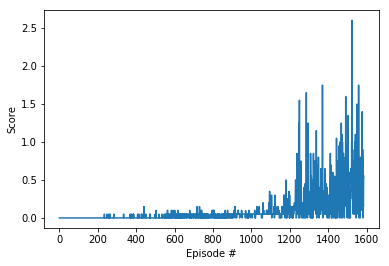

In [13]:
agent = DDPGAgent(state_size, action_size, num_agents, random_seed=0, resnet=False, prioritized_replay=False)

# Train the Network
scores = ddpg('DDPG')

# Plot the Scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### Comments:

Viola.  Environment solved in 1485 episodes using a similar setup to the one I had in the last project.

Let's now try to have some fun as this is the final project of this course and there are a bunch of things I've been wanting to experiment with...

## 2. DDPG with Prioritized Experience Replay

Okay, let's implement Prioritized Experience Replay and see how the algorithm performs vs. without.

DDPG


//anaconda/envs/drlnd/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in double_scalars


Episode 100	Average Score: -0.00500	Latest Score: -0.00500	2018-12-23 07:08:41.522505
		Ave. Score Player 0: -0.005099999886006117	Ave. Score Player 1: -0.0048999998904764655
Episode 200	Average Score: -0.00500	Latest Score: -0.00500	2018-12-23 07:11:10.883532
		Ave. Score Player 0: -0.004599999897181988	Ave. Score Player 1: -0.005399999879300594
Episode 300	Average Score: -0.00500	Latest Score: -0.00500	2018-12-23 07:13:05.504837
		Ave. Score Player 0: -0.004799999892711639	Ave. Score Player 1: -0.005199999883770943
Episode 400	Average Score: -0.00500	Latest Score: -0.00500	2018-12-23 07:15:35.550001
		Ave. Score Player 0: -0.004399999901652336	Ave. Score Player 1: -0.005599999874830246
Episode 500	Average Score: -0.00500	Latest Score: -0.00500	2018-12-23 07:17:49.346903
		Ave. Score Player 0: -0.0064999998547136785	Ave. Score Player 1: -0.0034999999217689036
Episode 600	Average Score: -0.00500	Latest Score: -0.00500	2018-12-23 07:19:12.488146
		Ave. Score Player 0: -0.005199999883770

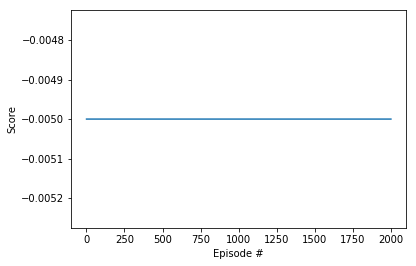

In [14]:
agent = DDPGAgent(state_size, action_size, num_agents, random_seed=0, resnet=False, prioritized_replay=True)

# Train the Network
scores = ddpg('DDPG')

# Plot the Scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### Comments:

It appears I have an error ("divide by zero").  I suspect that my prioritized replay buffer is getting some empty experiences and this needs to be addressed.

In addition, it is clear that my implementation of Prioritized Experience Replay has some issues and is not learning.  I would appreciate any suggestions as to why it's not learning and how to get this working.  

When I have time, would be great to get it running--but as time is short and I'd like to complete this course, will need to pursue sometime in the future.

## 3. DDPG with Residual Network

Okay, let's just make sure my Residual Network "experiment" can converge within a reasonable amount of epochs.  Granted it will run slowly on my CPU, but let's go for it!

DDPG_Resnet
Episode 100	Average Score: -0.00450	Latest Score: -0.00500	2018-12-23 11:30:32.311833
		Ave. Score Player 0: -0.003399999886751175	Ave. Score Player 1: -0.005599999874830246
Episode 200	Average Score: -0.00450	Latest Score: -0.00500	2018-12-23 11:32:15.436886
		Ave. Score Player 0: -0.005699999872595072	Ave. Score Player 1: -0.003299999888986349
Episode 300	Average Score: -0.00100	Latest Score: -0.00500	2018-12-23 11:34:09.200526
		Ave. Score Player 0: 0.0004000001773238182	Ave. Score Player 1: -0.002399999834597111
Episode 400	Average Score: 0.02200	Latest Score: 0.04500	2018-12-23 11:37:03.988377
		Ave. Score Player 0: 0.020500000435858964	Ave. Score Player 1: 0.023500000592321157
Episode 500	Average Score: 0.01650	Latest Score: -0.00500	2018-12-23 11:39:41.676346
		Ave. Score Player 0: 0.017200000435113907	Ave. Score Player 1: 0.015800000466406346
Episode 600	Average Score: 0.04450	Latest Score: -0.00500	2018-12-23 11:43:32.786954
		Ave. Score Player 0: 0.049600000847131

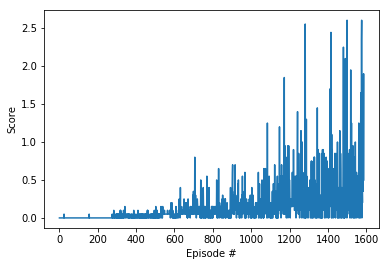

In [15]:
agent = DDPGAgent(state_size, action_size, num_agents, random_seed=0, resnet=True, prioritized_replay=False)

# Train the Network
scores = ddpg('DDPG_Resnet')

# Plot the Scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### Comments:

Hurray--Residual Network seems to work well and continued to learn and converge.  

It would be pretty easy to add more layers, train on a GPU and be ready to solve far more complex environments.

Also, I realize my implementation was naive.  I just threw a bunch of residual layers into the middle of my network.  Usually, residual layers are added together with convolutions at the front of the network.  But at least I've tried working with residual layers and found that they are pretty easy to implement.

In [ ]:
# Watch the trained agent run

env_info = env.reset(train_mode=False)[brain_name] 
states = env_info.vector_observations
scores = np.zeros(num_agents)

for x in range(500):
    actions = agent.act(states, add_noise=False)
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    states = next_states
    scores += rewards
    if np.any(dones):
        break
        


In [ ]:
env.close()

## Further work to be considered

This course has ended too early for me (just when it was starting to get exciting!) and I really wish there was more time spent applying and experimenting with the latest methods and techniques.

I need some more time (or a little help!) to correct errors and get Prioritized Experience Replay fully working.  I will keep this code posted on GitHub and if anyone does correct my errors, I'd be very pleased to know and update the Prioritized Experience Replay code accordingly.  (If it's any consolation, I found several attempts to implement DDPG with Prioritized Replay using Pytorch--but none appeared to be fully implemented or operating well...  Given work and other constraints, I don't currently have the time to complete this effort.)  Of course, if I have time, I will revisit this and update the code.

I started to implement "stacked frames" of experiences so the network would have a recent memory but didn't have time to complete (mostly because I was struggling to implement Prioritized Experience Replay).  I suspect that by stacking frames the network may be able to converge better--and this is worth testing.

I'd really like to experiment with D4PG and PPO and compare the two methods and their strenghts and weaknesses.  My implementation in this project used a single learning agent and if I had more time I would have implemented MADDPG (which seems like it would have been a fairly trivial addition).

Would be also great to apply and play with Hindsight Experience Replay ("HER") (*see* https://arxiv.org/pdf/1707.01495.pdf)

In addition, wish there was more time to experiment with the techniques used in Alpha Zero for multi-player environments *as well as in single action environments* where multiple actors might improve in parallel and the better performer is continuously chosen.  The techniques applied by Deep Mind in Alpha Zero are so simple and brilliant (and clearly are extremely effective!) that they deserve more attention.

Look forward to exploring techniques learned in this course for other projects.  I am far more familiar with Tensor Flow and Keras and look forward to implementing the more advanced RL algorithms in these platforms where I have a bit more experience.  (but appreciated getting familiar with Pytorch--which for most, but not all, things has proved to be fairly straightforward)